In [1]:
%load_ext tensorboard
from os import path, listdir, mkdir
import pandas as pd
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from zipfile import ZipFile
from PIL import Image
from keras.callbacks import History
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
import time
from sklearn.model_selection import train_test_split
from shutil import copyfile
from tensorflow.keras.applications.vgg16 import VGG16
history = History()

In [2]:
#filename = 'brain_tumors.zip'
#with ZipFile(filename, 'r') as zip:
#    print('Extracting files')
#    zip.extractall("./brain_tumors/images")
#    print('Done')

In [3]:
no_pic_names = [fn for fn in listdir("./brain_tumors/images/no")]
yes_pic_names = [fn for fn in listdir("./brain_tumors/images/yes")]
for fn in yes_pic_names:
    no_pic_names.append(fn)
no_pic_names

pic_dict = {}
for fn in no_pic_names:
    if 'n' in fn.lower():
        pic_dict[fn] = "0"
    else:
        pic_dict[fn] = "1"
        
tumor_labels = pd.DataFrame({'filename': list(pic_dict.keys()), 'class': list(pic_dict.values())})
tumor_labels

,filename,class
0,1 no.jpeg,0
1,10 no.jpg,0
2,11 no.jpg,0
3,12 no.jpg,0
4,13 no.jpg,0
...,...,...
248,Y95.jpg,1
249,Y96.jpg,1
250,Y97.JPG,1
251,Y98.JPG,1


In [4]:
# Create a train-test split and move the files from each yes and no into a train and a test folder
train, test = train_test_split(tumor_labels, test_size=0.2, stratify=tumor_labels['class'])

# Create a timestamp for the iterations of the train and test folders
TIME = time.time()

# Filepaths for where the images are and where they need to be
no_prefix = "./brain_tumors/images/no/"
yes_prefix = "./brain_tumors/images/yes/"
train_dst = "./brain_tumors/train-{}/".format(TIME)
test_dst = "./brain_tumors/test-{}/".format(TIME)

# Create train and test directories if they don't already exist
if not path.exists(train_dst):
    mkdir(train_dst)

if not path.exists(test_dst):
    mkdir(test_dst)

# Copy images that exist in the "yes" and "no" folders and separate them as train and test based on the train test split
for fn in tumor_labels.iterrows():
    if 'n' in fn[1][0].lower().split(".")[0]:
        copyfile(no_prefix+fn[1][0], train_dst+fn[1][0])
        image = Image.open(no_prefix+fn[1][0])
        image = image.resize((96, 96), Image.ANTIALIAS)
        rgb_im = image.convert('RGB')
        image.save(fn[1][0], 'PNG', quality=90)
    else:
        copyfile(yes_prefix+fn[1][0], train_dst+fn[1][0])
        image = Image.open(yes_prefix+fn[1][0])
        image = image.resize((96, 96), Image.ANTIALIAS)
        rgb_im = image.convert('RGB')
        quality_val = 90
        image.save(fn[1][0], 'PNG', quality=quality_val)
        
for fn in test.iterrows():
    if 'n' in fn[1][0].lower().split(".")[0]:
        copyfile(no_prefix+fn[1][0], test_dst+fn[1][0])
        image = Image.open(test_dst+fn[1][0])
        image = image.resize((96, 96), Image.ANTIALIAS)
        rgb_im = image.convert('RGB')
        image.save(fn[1][0], 'PNG', quality=90)
    else:
        copyfile(yes_prefix+fn[1][0], test_dst+fn[1][0])
        image = Image.open(test_dst+fn[1][0])
        image = image.resize((96, 96), Image.ANTIALIAS)
        rgb_im = image.convert('RGB')
        image.save(fn[1][0], 'PNG', quality=90)

In [5]:
# Find the max pixel width and height of all images
def get_pixel_measurement(filepath):
    height, length = Image.open(filepath).size
    #print(Image.open(filepath).mode)
    return (height, length)

length = 0
height = 0

for fn in listdir("./brain_tumors/images/no"):
    measurements = get_pixel_measurement(no_prefix + "/" + fn)
    if measurements[0] > height:
        height = measurements[0]
    if measurements[1] > length:
        length = measurements[1]

for fn in listdir("./brain_tumors/images/yes"):
    measurements = get_pixel_measurement(yes_prefix + "/" + fn)
    if measurements[0] > height:
        height = measurements[0]
    if measurements[1] > length:
        length = measurements[1]
        
print(length, height)

1427 1920


In [6]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split = 0.4
)

train_generator = train_datagen.flow_from_dataframe(
    tumor_labels, 
    train_dst,
    x_col='filename',
    y_col='class',
    class_mode='binary',
    color_mode='rgb',
    batch_size=4,
    subset = 'training'
)

val_generator = train_datagen.flow_from_dataframe(
        tumor_labels,
        test_dst,
        x_col='filename',
        y_col='class',
        color_mode='rgb',
        batch_size=4,
        class_mode='binary',
        subset='validation'
)

Found 152 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


G:\Anaconda\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 202 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [7]:
conv = VGG16(input_shape=(96, 96, 3), 
             weights='imagenet', 
             include_top=False)

In [8]:
x = conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
pred = Dense(1, activation='sigmoid')(x)

model = Model(inputs = conv.input,
              outputs=pred)

In [9]:
NAME = 'brain-tumor-identification-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/{}'.format(NAME))

In [10]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 8020), started 1 day, 22:34:28 ago. (Use '!kill 8020' to kill it.)

In [11]:
model.compile(loss="binary_crossentropy", 
              metrics = ['accuracy', "Precision", "Recall"], 
              optimizer='sgd')

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [13]:
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=val_generator,
                    shuffle=True,
                    callbacks=[tensorboard])

Epoch 1/10
38/38 [==============================] - 45s 1s/step - loss: 0.1970 - accuracy: 0.8830 - precision: 0.9660 - recall: 0.8905 - val_loss: 5.7950 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 42s 1s/step - loss: 0.1471 - accuracy: 0.9791 - precision: 0.9791 - recall: 1.0000 - val_loss: 5.5650 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 43s 1s/step - loss: 0.0361 - accuracy: 0.9948 - precision: 0.9948 - recall: 1.0000 - val_loss: 5.1065 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 42s 1s/step - loss: 0.0462 - accuracy: 0.9931 - precision: 0.9931 - recall: 1.0000 - val_loss: 5.2474 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 42s 1s/step 

In [14]:
model.evaluate(val_generator)

5/5 [==============================] - 1s 239ms/step - loss: 5.2354 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00


[5.2353692054748535, 0.0, 0.0, 0.0]

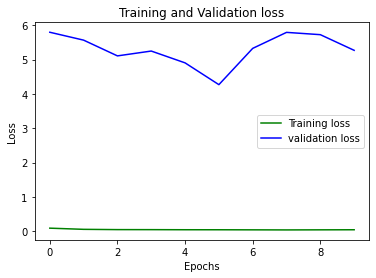

In [15]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

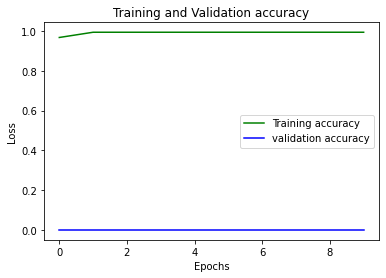

In [16]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

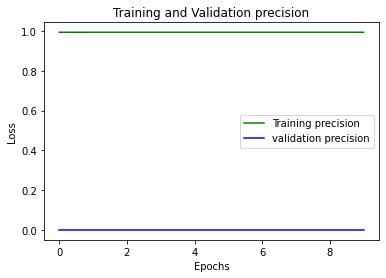

In [17]:
loss_train = history.history['precision']
loss_val = history.history['val_precision']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'g', label='Training precision')
plt.plot(epochs, loss_val, 'b', label='validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()